# Autoencoder
*Written by Viviane Clay*

Autoencoder trained on observations from the Obstacle Tower environment.
## Setup
### Import Dependencies

In [1]:
import os
import numpy as np;
import pandas as pd
import matplotlib.pyplot as plt
from scipy import misc
from keras.models import Sequential,Model
from keras.layers.convolutional import Conv3D, Conv2D, UpSampling2D,Conv2DTranspose
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
from keras.layers import Dense,MaxPooling2D,TimeDistributed,Input,concatenate,Flatten,Reshape,LSTM,Lambda
import tensorflow as tf
import tensorflow.contrib.layers as c_layers
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns

Using TensorFlow backend.
c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:520: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:521: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\vkakerbeck\miniconda3\lib\site-packages\tensorflow\py

In [2]:
# adapt path as necessary.
path = './Results/TowerTraining/Recordings/Standard/3999_16.100/autoencoder/'

### Define Autoencoder Network

In [5]:
from keras import backend as K
K.clear_session()

def swish(input_activation):
    """Swish activation function. For more info: https://arxiv.org/abs/1710.05941"""
    return tf.multiply(input_activation, tf.nn.sigmoid(input_activation))

inImg = Input(batch_shape=(None,168, 168, 3),name="input_1")
conv = Conv2D(filters=16, kernel_size=[8, 8], strides=[4, 4],activation=tf.nn.elu, name="conv_1")(inImg)
print(conv)
conv = Conv2D(filters=32, kernel_size=[4, 4], strides=[2, 2],activation=tf.nn.elu, name="conv_2")(conv)
print(conv)
flat = Reshape((19*19*32,))(conv)#Flatten()(conv)
print(flat)
dens = Dense(256,activation=swish,kernel_initializer=c_layers.variance_scaling_initializer(1.0), name="dens_1")(flat)
print(dens)
enc = Dense(256,activation=swish,kernel_initializer=c_layers.variance_scaling_initializer(1.0), name="dens_2")(dens)
print(enc)
de_dens = Dense(20*20*32,activation=swish,kernel_initializer=c_layers.variance_scaling_initializer(1.0), name="dens_3")(enc)
print(de_dens)
shaped = Reshape((20, 20, 32))(de_dens)
print(shaped)
de_conv = Conv2DTranspose(filters=16, kernel_size=[4, 4], strides=[2, 2],activation=tf.nn.elu, name="deconv_1")(shaped)
print(de_conv)
prediction = Conv2DTranspose(filters=3, kernel_size=[8, 8], strides=[4, 4],padding='same',activation=tf.nn.elu, name="deconv_3")(de_conv)
print(prediction)
model = Model(inputs=inImg, outputs=prediction)

optimizer = tf.train.AdamOptimizer(0.0001)
model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['accuracy','mse'])

Tensor("conv_1/Elu:0", shape=(?, 41, 41, 16), dtype=float32)
Tensor("conv_2/Elu:0", shape=(?, 19, 19, 32), dtype=float32)
Tensor("reshape_1/Reshape:0", shape=(?, 11552), dtype=float32)
Tensor("dens_1/Mul:0", shape=(?, 256), dtype=float32)
Tensor("dens_2/Mul:0", shape=(?, 256), dtype=float32)
Tensor("dens_3/Mul:0", shape=(?, 12800), dtype=float32)
Tensor("reshape_2/Reshape:0", shape=(?, 20, 20, 32), dtype=float32)
Tensor("deconv_1/Elu:0", shape=(?, ?, ?, 16), dtype=float32)
Tensor("deconv_3/Elu:0", shape=(?, ?, ?, 3), dtype=float32)


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 168, 168, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 41, 41, 16)        3088      
_________________________________________________________________
conv_2 (Conv2D)              (None, 19, 19, 32)        8224      
_________________________________________________________________
reshape_1 (Reshape)          (None, 11552)             0         
_________________________________________________________________
dens_1 (Dense)               (None, 256)               2957568   
_________________________________________________________________
dens_2 (Dense)               (None, 256)               65792     
_________________________________________________________________
dens_3 (Dense)               (None, 12800)             3289600   
__________

### Define Data Loading & Augmentation

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    directory=path+'Data/ObstacleTower/',
    target_size=(168, 168),
    color_mode="rgb",
    batch_size=256,
    class_mode="input",
    shuffle=True,
    seed=42
)

## Train Model

In [ ]:
info = model.fit_generator(train_generator,epochs=50)

### Plot Training Progress

In [ ]:
plt.plot(info.history['loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.show()

## Save Model

In [ ]:
model.save_weights(path+'autoencoder/aemodelAdam50E.h5')

## Load Trained Model

In [12]:
model.load_weights('./Results/TowerTraining/Recordings/Standard/3999_16.100/autoencoder/aemodelAdam50E.h5')

### Load Test Run & Process

In [14]:
folder_name = '3999_16.100'
path = './Results/TowerTraining/Recordings/Standard/'+folder_name+'/'

obs = np.load(path+'visobs.npy', mmap_mode='r')

out = model.predict(obs)

#### Get Hidden Layer Activations

In [18]:
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=[model.get_layer('dens_2').output,model.get_layer('deconv_3').output])
intermediate_output = intermediate_layer_model.predict(obs)

#### Save

In [16]:
np.save(path+'AEOutAdam.npy',out)
np.save(path+'AEActAdam.npy',intermediate_output[0])

(4000, 168, 168, 3)

### Visualize Image Reconstruction

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


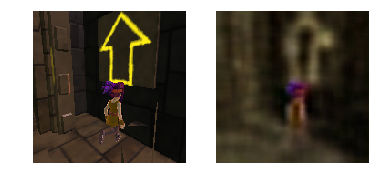

In [17]:
i=60
#out = model.predict(obs[i].reshape((1,168,168,3)))
plt.figure()
plt.subplot(1,2,1)
plt.imshow(obs[i])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(out[i])
plt.axis('off')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


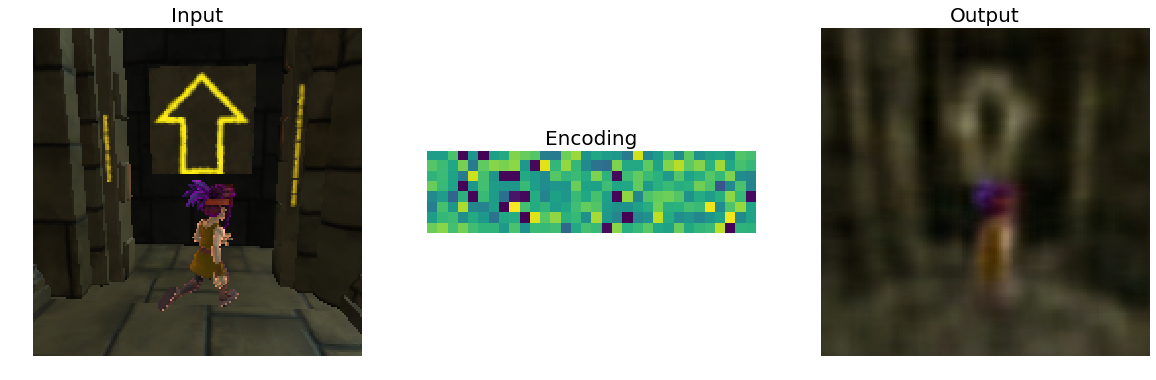

In [19]:
i=223
plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.imshow(obs[i])
plt.title('Input',fontsize=20)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(intermediate_output[0][i].reshape((8,32)))
plt.title('Encoding',fontsize=20)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(intermediate_output[1][i])
plt.title('Output',fontsize=20)
plt.axis('off')
plt.show()
#plt.savefig(path+'autoencoder/Example1.png', bbox_inches='tight')

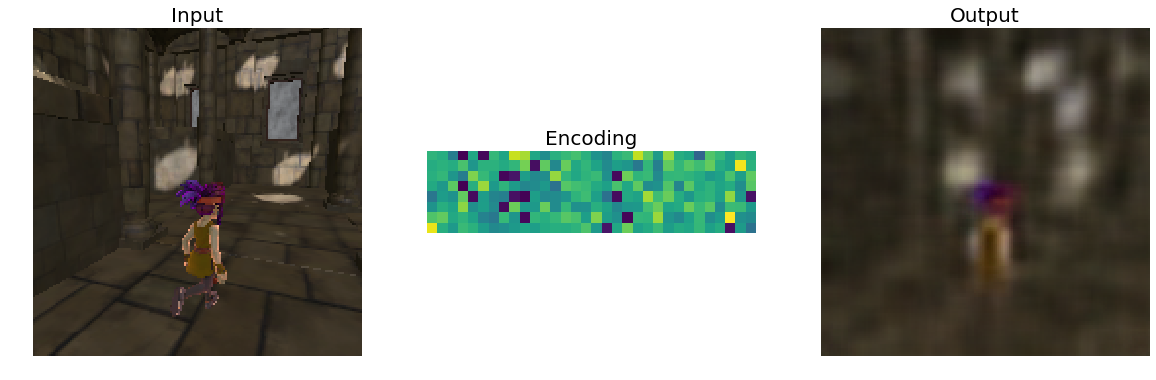

In [20]:
i=705
plt.figure(figsize=(20,7))
plt.subplot(1,3,1)
plt.imshow(obs[i])
plt.title('Input',fontsize=20)
plt.axis('off')
plt.subplot(1,3,2)
plt.imshow(intermediate_output[0][i].reshape((8,32)))
plt.title('Encoding',fontsize=20)
plt.axis('off')
plt.subplot(1,3,3)
plt.imshow(intermediate_output[1][i])
plt.title('Output',fontsize=20)
plt.axis('off')
#plt.show()
plt.savefig(path+'autoencoder/Example3.png', bbox_inches='tight')